In [1]:
# load libraries and define some functions

# functions are 
# ATL06_dict
# transform_coord
# read_DEM_index (to read Arctic DEM shapefile)

import os
import rasterio as rio
from matplotlib import pyplot as plt
import numpy as np
import glob
import pyproj
from shapely.geometry import MultiPoint, Point
import h5py
import pandas as pd
import geopandas as gpd

# transform function
def transform_coord(proj1, proj2, x, y):
    """
    Transform coordinates from proj1 to proj2 (EPSG num).

    Example EPSG projs:
        Geodetic (lon/lat): 4326
        Polar Stereo AnIS (x/y): 3031
        Polar Stereo GrIS (x/y): 3413
    """
    # Set full EPSG projection strings
    proj1 = pyproj.Proj("+init=EPSG:"+str(proj1))
    proj2 = pyproj.Proj("+init=EPSG:"+str(proj2))
    return pyproj.transform(proj1, proj2, x, y)  # convert


def ATL06_to_dict(filename, dataset_dict):
    """
        Read selected datasets from an ATL06 file

        Input arguments:
            filename: ATl06 file to read
            dataset_dict: A dictinary describing the fields to be read
                    keys give the group names to be read, 
                    entries are lists of datasets within the groups
        Output argument:
            D6: dictionary containing ATL06 data.  Each dataset in 
                dataset_dict has its own entry in D6.  Each dataset 
                in D6 contains a list of numpy arrays containing the 
                data
    """
    
    D6=[]
    pairs=[1, 2, 3]
    beams=['l','r']
    # open the HDF5 file
    with h5py.File(filename) as h5f:
        # loop over beam pairs
        for pair in pairs:
            # loop over beams
            for beam_ind, beam in enumerate(beams):
                # check if a beam exists, if not, skip it
                if '/gt%d%s/land_ice_segments' % (pair, beam) not in h5f:
                    continue
                # loop over the groups in the dataset dictionary
                temp={}
                for group in dataset_dict.keys():
                    for dataset in dataset_dict[group]:
                        DS='/gt%d%s/%s/%s' % (pair, beam, group, dataset)
                        # since a dataset may not exist in a file, we're going to try to read it, and if it doesn't work, we'll move on to the next:
                        try:
                            temp[dataset]=np.array(h5f[DS])
                            # some parameters have a _FillValue attribute.  If it exists, use it to identify bad values, and set them to np.NaN
                            if '_FillValue' in h5f[DS].attrs:
                                fill_value=h5f[DS].attrs['_FillValue']
                                bad=temp[dataset]==fill_value
                                temp[dataset]=np.float64(temp[dataset])
                                temp[dataset][bad]=np.NaN
                        except KeyError as e:
                            pass
                if len(temp) > 0:
                    # it's sometimes convenient to have the beam and the pair as part of the output data structure: This is how we put them there.
                    temp['pair']=np.zeros_like(temp['h_li'])+pair
                    temp['beam']=np.zeros_like(temp['h_li'])+beam_ind
                    temp['filename']=filename
                    D6.append(temp)
    return D6

#-- PURPOSE: read zip file containing index shapefiles for finding DEM tiles
# function from T. Sutterley


def read_DEM_index(elevation_index_file, HEM):
    
    import zipfile
    import io
    
    #-- extract zip file with shapefile index
    zs = zipfile.ZipFile(elevation_index_file)
    dbf,prj,shp,shx = [io.BytesIO(zs.read(s)) for s in sorted(zs.namelist())]
    #-- read the shapefile and extract entities
    shape_input = shapefile.Reader(dbf=dbf,prj=prj,shp=shp,shx=shx)
    shape_entities = shape_input.shapes()
    shape_attributes = shape_input.records()
    shape_field_names = [f[0] for f in shape_input.fields[1:]]
    #-- extract attribute indice for DEM tile (REMA) or objectid (ArcticDEM)
    if (HEM == 'S'):
        #-- REMA index file attributes:
        #-- name: DEM mosaic name for tile (file name without suffix)
        #-- tile: DEM tile identifier (IMy_IMx)
        #-- nd_value: fill value for elements with no data
        #-- resolution: DEM horizontal spatial resolution (meters)
        #-- creationda: creation date
        #-- raster: (empty)
        #-- fileurl: link to file on PGC server
        #-- spec_type: specific type (DEM)
        #-- qual: density of scenes within tile (0 to 1)
        #-- reg_src: DEM registration source (ICESat or neighbor align)
        #-- num_gcps: number of ground control points
        #-- meanresz: mean vertical residual (meters)
        #-- active: (1)
        #-- qc: (2)
        #-- rel_ver: release version
        #-- num_comp: number of components
        #-- st_area_sh: tile area (meters^2)
        #-- st_length_: perimeter length of tile (meters)
        ind, = [i for i,f in enumerate(shape_field_names) if (f == 'tile')]
    elif (HEM == 'N'):
        #-- ArcticDEM index file attributes:
        #-- objectid: DEM tile object identifier for sub-tile
        #-- name: DEM mosaic name for sub-tile (file name without suffix)
        #-- tile: DEM tile identifier (IMy_IMx) (non-unique for sub-tiles)
        #-- nd_value: fill value for elements with no data
        #-- resolution: DEM horizontal spatial resolution (meters)
        #-- creationda: creation date
        #-- raster: (empty)
        #-- fileurl: link to file on PGC server
        #-- spec_type: specific type (DEM)
        #-- qual: density of scenes within tile (0 to 1)
        #-- reg_src: DEM registration source (ICESat or neighbor align)
        #-- num_gcps: number of ground control points
        #-- meanresz: mean vertical residual (meters)
        #-- active: (1)
        #-- qc: (2)
        #-- rel_ver: release version
        #-- num_comp: number of components
        #-- st_area_sh: tile area (meters^2)
        #-- st_length_: perimeter length of tile (meters)
        ind, = [i for i,f in enumerate(shape_field_names) if (f == 'objectid')]
    #-- create python dictionary for each polygon object
    poly_dict = {}
    attrs_dict = {}
    #-- extract the entities and assign by tile name
    for i,ent in enumerate(shape_entities):
        #-- name or objectid of tile
        tile = str(shape_attributes[i][ind])
        #-- extract attributes and assign by tile
        attrs_dict[tile] = {}
        for j,field in enumerate(shape_field_names):
            attrs_dict[tile][field] = shape_attributes[i][j]
        #-- extract Polar Stereographic coordinates for entity
        points = np.array(ent.points)
        poly_obj = Polygon(list(zip(points[:,0], points[:,1])))
        #-- Valid Polygon may not possess overlapping exterior or interior rings
        if (not poly_obj.is_valid):
            poly_obj = poly_obj.buffer(0)
        poly_dict[tile] = poly_obj
    #-- close the zipfile
    zs.close()
    #-- return the dictionaries of polygon objects and attributes
    return poly_dict,attrs_dict


In [2]:
# this finds the correct tile index in the Arctic DEM shapefile and puts the bounding box into dem_bbox

dem_file = '40_06_1_2_2m_v3.0'

import shapefile
from shapely.geometry import Polygon, MultiPoint

poly_dict, attrs_dict = read_DEM_index('/home/jovyan/glaciersat2/arcticDEM/ArcticDEM_Tile_Index_Rel7.zip', HEM='N')

for key in attrs_dict.keys():
    if attrs_dict[key]['name']==dem_file:
        tile_key = key
        dem_bbox = poly_dict[tile_key]
        break


In [3]:
# load an Arctic DEM tile

adem = '/home/jovyan/glaciersat2/arcticDEM/' + dem_file + '_reg_dem.tif'

#This is rasterio Dataset object
src_proj = rio.open(adem)

# read the DEM file
adem_proj = src_proj.read(1).astype(float)
adem_proj[adem_proj==src_proj.nodata] = np.nan

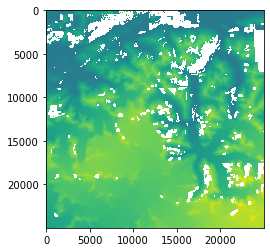

In [7]:
plt.imshow(adem_proj)


In [4]:
# load icesat-2 tracks

files = glob.glob('/home/jovyan/glaciersat2/juneauicefield/*.h5')

dataset_dict={'land_ice_segments':['h_li','longitude','latitude','atl06_quality_summary','delta_time']}
# atl06_quality_summary is binary, 1 for good

x_ps = np.array([])
y_ps = np.array([])
dz = np.array([])
good = np.array([])
isat_time = np.array([])

for file in files:
    new_data = ATL06_to_dict(file, dataset_dict)
    
    # look at all beams
    
    for beam in range(len(new_data)):
        # convert to epsg 3413
        x,y = transform_coord('4326','3413', new_data[beam]['longitude'], new_data[beam]['latitude'])
    
        # convert to MultiPoint and test whether the track is in the DEM polygon
       
        points = MultiPoint(list(zip(x,y)))
        
        int_test = dem_bbox.intersects(points) # True if there are common points
        if int_test:
            
            int_map = list(map(dem_bbox.intersects,points)) # which points are inside?
            
            x_inside = x[int_map]
            y_inside = y[int_map]
            qual = new_data[beam]['atl06_quality_summary'][int_map]
            seg_time = new_data[beam]['delta_time'][int_map]
            
            atl_coord = list(zip(x_inside,y_inside))
            
            adem_sample = list((src_proj.sample(atl_coord, 1)))
            adem_sample_elev = np.squeeze(adem_sample).astype(float)
            
            dh = new_data[beam]['h_li'][int_map]-adem_sample_elev
            
            # crude filter
            dh[np.abs(dh)>10] = np.nan
            
            x_ps = np.hstack((x_ps, x_inside))
            y_ps = np.hstack((y_ps, y_inside))
            dz = np.hstack((dz, dh))
            good = np.hstack((good,qual))
            isat_time = np.hstack((isat_time,seg_time))
            

/srv/conda/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in greater


In [5]:
# make pandas, geopandas, plot things

%matplotlib widget

dz_df = pd.DataFrame()
dz_df['x'] = x_ps
dz_df['y'] = y_ps
dz_df['dz'] = dz
dz_df['good'] = good
dz_df['ice_sat_time'] = isat_time

dz_df.plot(x='x', y='y', kind='scatter', c='dz', s=1, cmap='RdBu')

dz_df['geometry'] = list(zip(dz_df['x'], dz_df['y']))
dz_df['geometry'] = dz_df['geometry'].apply(Point)

dz_gdf = gpd.GeoDataFrame(dz_df, crs={'init' :'epsg:3413'})

FigureCanvasNbAgg()

In [9]:
dz_df.hist('dz',bins=128)

FigureCanvasNbAgg()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdbe208bbe0>]],
      dtype=object)

In [6]:
idx = dz_df['ice_sat_time']<2.6e7
dz_df_t1 = dz_df[idx]

idx = ((dz_df['ice_sat_time']>2.6e7) & (dz_df['ice_sat_time']<2.8e7))
dz_df_t2 = dz_df[idx]

idx = ((dz_df['ice_sat_time']>2.8e7) & (dz_df['ice_sat_time']<3.2e7))
dz_df_t3 = dz_df[idx]

idx = (dz_df['ice_sat_time']>3.2e7)
dz_df_t4 = dz_df[idx]

t1=dz_df_t1['ice_sat_time']/86400
t2=dz_df_t2['ice_sat_time']/86400
t3=dz_df_t3['ice_sat_time']/86400
t4=dz_df_t4['ice_sat_time']/86400
fig, axa = plt.subplots()
plt.hist([dz_df_t4['dz'], dz_df_t3['dz'], dz_df_t2['dz'], dz_df_t1['dz']], bins=32, stacked=False, rwidth=1, 
         label=['Day '+ str(int(np.mean(t4))), 'Day '+ str(int(np.mean(t3))), 'Day '+ str(int(np.mean(t2))), 
                'Day '+ str(int(np.mean(t1)))])
plt.legend(title='Days since 1 Jan 2018')
plt.title('dz histograms')



FigureCanvasNbAgg()

Text(0.5, 1.0, 'dz histograms')

In [10]:
# #Fetch the zip file for Region 01 (Alaska)
# #Use the wget command (the -nc is "no-clobber", so will not overwrite existing file)
# !wget -nc https://www.glims.org/RGI/rgi60_files/01_rgi60_Alaska.zip
    
# #Extract to rgi subdirectory
# !unzip -n -d rgi 01_rgi60_Alaska.zip

--2019-06-21 05:02:13--  https://www.glims.org/RGI/rgi60_files/01_rgi60_Alaska.zip
Resolving www.glims.org (www.glims.org)... 128.138.135.43
Connecting to www.glims.org (www.glims.org)|128.138.135.43|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 82224693 (78M) [application/zip]
Saving to: ‘01_rgi60_Alaska.zip’

01_rgi60_Alaska.zip 100%[===================>]  78.42M  26.7MB/s    in 2.9s    

2019-06-21 05:02:17 (26.7 MB/s) - ‘01_rgi60_Alaska.zip’ saved [82224693/82224693]

Archive:  01_rgi60_Alaska.zip
  inflating: rgi/01_rgi60_Alaska.dbf  
  inflating: rgi/01_rgi60_Alaska.prj  
  inflating: rgi/01_rgi60_Alaska.shp  
  inflating: rgi/01_rgi60_Alaska.shx  
  inflating: rgi/01_rgi60_Alaska_hypso.csv  


In [18]:
#Specify the shapefile filename
rgi_fn = 'rgi/01_rgi60_Alaska.shp'

# read into a geopanda
rgi_gdf = gpd.read_file(rgi_fn)

#By default a new integer index is created.  Let's just use the RGI ID as our index
rgi_gdf = rgi_gdf.set_index('RGIId')

polys1 = gpd.GeoSeries(dem_bbox)
dem_gpd = gpd.GeoDataFrame({'geometry': polys1}, crs={'init' :'epsg:3413'})
rgi_gdf_idx = rgi_gdf.intersects(dem_gpd)

rgi_gdf_idx.plot();

TypeError: Empty 'DataFrame': no numeric data to plot

In [ ]:
for k in range(len(rgi_gdf)):
    lon,lat = rgi_gdf.geometry[k].exterior.coords.xy
    x, y = transform_coord('4326','3413', lon,lat)
    rgi_gdf.geometry[k] = Polygon(list(zip(x,y)))


/srv/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [34]:
list(zip(x,y))

[(-2837683.504833113, 593755.4626398744),
 (-2837955.9221104053, 593793.7067402614),
 (-2838109.618811966, 593819.6432730112),
 (-2838101.958767138, 593864.5010720018),
 (-2838102.012487872, 593891.6048134225),
 (-2838107.621416086, 593919.8873079853),
 (-2838113.9033860504, 593954.1182962577),
 (-2838126.413213577, 593995.4764731134),
 (-2838136.2853549826, 594040.1452191446),
 (-2838145.091621996, 594080.7175903773),
 (-2838145.145806723, 594082.2289563082),
 (-2838144.759895764, 594081.6290037878),
 (-2838144.997047582, 594085.0515405018),
 (-2838147.3337001675, 594099.6013344796),
 (-2838152.607516209, 594125.8697291303),
 (-2838159.2537890505, 594156.127884382),
 (-2838168.150748263, 594200.1778709618),
 (-2838173.296542413, 594221.2414148038),
 (-2838176.9416318103, 594233.1103003151),
 (-2838181.4083074206, 594251.5640791899),
 (-2838183.6013611606, 594270.274952502),
 (-2838184.0066323723, 594273.581232113),
 (-2838183.9479375007, 594273.5655812984),
 (-2838189.5685714665, 5943